In [56]:
import os
import cv2
import matplotlib.pyplot as plt
import functools

filenames = []

for root, dirs, files in os.walk('/Users/felixminzenmay/Code/datasets/ffhq'):
    for file in files:
        if file.endswith(".png"):
            filename = root + "/" + file
            filenames.append(filename)



In [57]:
len(filenames)

70000

(128, 128, 3)


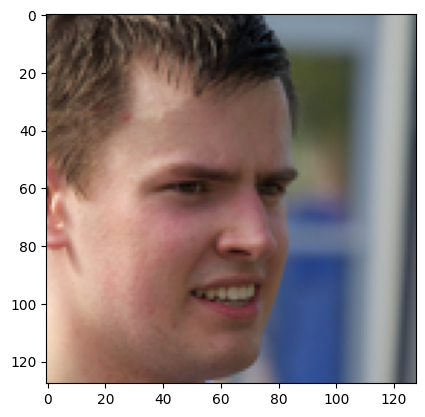

In [58]:
img = cv2.imread(filenames[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

In [59]:
hparams = {
    "lr": 1e-3,
    "eps": 1e-8,
    "batch_size": 32
}

In [60]:
from input_pipeline import load_images
imgs = load_images(batch_size=hparams["batch_size"])
train_iter = imgs.as_numpy_iterator()

In [61]:
import jax
from jax import numpy as jnp
from flax import linen as nn
import optax
import flax

In [62]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        #self.bn1 = nn.BatchNorm2d(out_ch)
        #self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        
        
        
        #h = self.bn1(self.relu(self.conv1(x)))
        
        h = self.relu(self.conv1(x))
        
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        
        #h = self.bn2(self.relu(self.conv2(h)))

        h = self.relu(self.conv2(h))
        
        # Down or Upsample
        return self.transform(h)

class Unet(nn.Module):
    """
    A simplified Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.sigma_emb = nn.Sequential(
                nn.Dense(time_emb_dim),
                nn.ReLU()
            )
        
        
        self.conv0 = nn.Conv(down_channels[0], 3)

        # Downsample
        self.downs = nn.ModuleList([ConvBlock(down_channels[i], down_channels[i+1], 
                                    time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([ConvBlock(up_channels[i], up_channels[i+1],
                                        time_emb_dim, up=True) for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        
        # Embedd time
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [63]:
################## Got this from yang song blog https://colab.research.google.com/drive/1SeXMpILhkJPjXUaesvzEhc3Ke6Zl_zxJ?usp=sharing#scrollTo=YyQtV7155Nht

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  embed_dim: int
  scale: float = 30.
  @nn.compact
  def __call__(self, x):    
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    W = self.param('W', jax.nn.initializers.normal(stddev=self.scale), 
                 (self.embed_dim // 2, ))
    W = jax.lax.stop_gradient(W)
    x_proj = x[:, None] * W[None, :] * 2 * jnp.pi
    return jnp.concatenate([jnp.sin(x_proj), jnp.cos(x_proj)], axis=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""  
  output_dim: int  
  
  @nn.compact
  def __call__(self, x):
    return nn.Dense(self.output_dim)(x)[:, None, None, :]    



class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture.
  
  Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
  """
  # marginal_prob_std: Any
  channels = (32, 64, 128, 256)
  embed_dim: int = 256
  
  @nn.compact
  def __call__(self, batch_noisy, sigmas, train):
    x, t = batch_noisy, sigmas
    # The swish activation function
    act = nn.swish
    # Obtain the Gaussian random feature embedding for t   
    embed = act(nn.Dense(self.embed_dim)(
        GaussianFourierProjection(embed_dim=self.embed_dim)(t)))
        
    # Encoding path
    h1 = nn.Conv(self.channels[0], (3, 3), (1, 1), padding='VALID',
                   use_bias=False)(x)    
    ## Incorporate information from t
    h1 += Dense(self.channels[0])(embed)
    ## Group normalization
    h1 = nn.GroupNorm(4)(h1)    
    h1 = act(h1)
    h2 = nn.Conv(self.channels[1], (3, 3), (2, 2), padding='VALID',
                   use_bias=False)(h1)
    h2 += Dense(self.channels[1])(embed)
    h2 = nn.GroupNorm()(h2)        
    h2 = act(h2)
    h3 = nn.Conv(self.channels[2], (3, 3), (2, 2), padding='VALID',
                   use_bias=False)(h2)
    h3 += Dense(self.channels[2])(embed)
    h3 = nn.GroupNorm()(h3)
    h3 = act(h3)
    h4 = nn.Conv(self.channels[3], (3, 3), (2, 2), padding='VALID',
                   use_bias=False)(h3)
    h4 += Dense(self.channels[3])(embed)
    h4 = nn.GroupNorm()(h4)    
    h4 = act(h4)

    # Decoding path
    h = nn.Conv(self.channels[2], (3, 3), (1, 1), padding=((2, 3), (2, 3)),
                  input_dilation=(2, 2), use_bias=False)(h4)    
    ## Skip connection from the encoding path
    h += Dense(self.channels[2])(embed)
    h = nn.GroupNorm()(h)
    h = act(h)
    h = nn.Conv(self.channels[1], (3, 3), (1, 1), padding=((2, 3), (2, 3)),
                  input_dilation=(2, 2), use_bias=False)(
                      jnp.concatenate([h, h3], axis=-1)
                  )
    h += Dense(self.channels[1])(embed)
    h = nn.GroupNorm()(h)
    h = act(h)
    h = nn.Conv(self.channels[0], (3, 3), (1, 1), padding=((2, 3), (2, 3)),
                  input_dilation=(2, 2), use_bias=False)(
                      jnp.concatenate([h, h2], axis=-1)
                  )    
    h += Dense(self.channels[0])(embed)    
    h = nn.GroupNorm()(h)  
    h = act(h)
    h = nn.Conv(1, (3, 3), (1, 1), padding=((2, 2), (2, 2)))(
        jnp.concatenate([h, h1], axis=-1)
    )

    # Normalize output
    #h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [64]:
class DenoisingModel(nn.Module):

    @nn.compact
    def __call__(self, batch_noisy, sigmas, train):
        batches, height, width, channels = batch_noisy.shape

        sigmas = sigmas[:, None]
        sigma_emb = nn.Dense(512)(sigmas)

        # x = nn.Conv(64, kernel_size=3, strides=3, padding='SAME')(batch_noisy)
        
        # residual_inputs = []
        # for down in self.downs:
        #     x = down(x, sigma_emb)
        #     residual_inputs.append(x)

        # x = nn.Dense()

        x = batch_noisy.reshape((batches, -1))
        x = nn.Dense(512)(x)

        x = jnp.concatenate([x, sigma_emb], axis=-1)

        x = nn.Dropout(0.1)(x, deterministic=not train)
        x = nn.Dense(512)(x)
        x = nn.Dropout(0.1)(x, deterministic=not train)
        x = nn.Dense(512)(x)
        x = nn.Dense(height * width * channels)(x)
        x = x.reshape((batches, height, width, channels))

        return x

In [65]:
#model = DenoisingModel()
model = ScoreNet()
optimizer = optax.adam(learning_rate=hparams['lr'], eps=hparams['eps'])

rng = jax.random.PRNGKey(0)

In [66]:
@flax.struct.dataclass # why do we need this? To be able to pass it to jit / grad
class TrainState:
    step: int
    params: flax.core.frozen_dict.FrozenDict
    tx: optax.OptState

def create_train_state(rng, sample_batch, sample_sigmas, model, optimizer):
    rng, init_rng, dropout_rng = jax.random.split(rng, 3)
    model_rng = {'params': init_rng, 'dropout': dropout_rng}
    params = model.init(model_rng, sample_batch, sample_sigmas, train=True)
    tx = optimizer.init(params)
    state = TrainState(step=0, params=params, tx=tx)
    return state

In [67]:
rng, init_rng = jax.random.split(rng)
sample_batch = train_iter.next()
sample_sigmas = jnp.ones((hparams["batch_size"]))
state = create_train_state(init_rng, sample_batch, sample_sigmas, model, optimizer)

In [68]:
def get_noise_levels(rng, nr_batches, sigma_min, sigma_max, sigma_data):
    # TODO understand and prettify
    
    min = sigma_min
    max = sigma_max
    loc = jnp.log(sigma_data)
    scale = 0.5


    min_cdf = nn.sigmoid((jnp.log(min) - loc) / scale)
    max_cdf = nn.sigmoid((jnp.log(max) - loc) / scale)
    u = jax.random.uniform(rng, (nr_batches,)) * (max_cdf - min_cdf) + min_cdf
    return jnp.exp(jnp.log(u / (1 - u)) * scale + loc)

shape: (3000,), mean: 0.07342693954706192, std: 0.0841161236166954,
min: 0.0050850845873355865, max: 0.9096322655677795


(array([2.38e+03, 4.16e+02, 1.14e+02, 4.70e+01, 1.70e+01, 1.20e+01,
        2.00e+00, 2.00e+00, 4.00e+00, 6.00e+00]),
 array([0.00508508, 0.0955398 , 0.18599452, 0.27644923, 0.36690396,
        0.45735869, 0.54781342, 0.63826811, 0.72872281, 0.81917757,
        0.90963227]),
 <BarContainer object of 10 artists>)

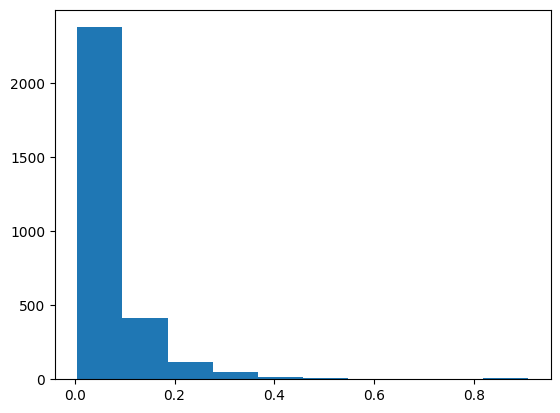

In [69]:
noise = get_noise_levels(jax.random.PRNGKey(2), 3000, 0.005, 1, 0.05)
print(f"shape: {noise.shape}, mean: {noise.mean()}, std: {noise.std()},\nmin: {noise.min()}, max: {noise.max()}")
plt.hist(noise)

In [70]:
def train_step(rng, model, optimizer, state, batch, loss_fn, get_noise_levels):
    rng, noise_rng, nl_rng, loss_rng = jax.random.split(rng, 4)

    noise = jax.random.normal(noise_rng, batch.shape)
    sigmas = get_noise_levels(rng=nl_rng, nr_batches=batch.shape[0])
    batch_noisy = batch + noise * sigmas[:,None,None,None] # TODO broadcasting??
    
    def loss_fn_wr(params):
        loss = loss_fn(loss_rng, model, params, batch_noisy, sigmas, batch)
        return jnp.mean(loss)
    
    value_and_grad_fn = jax.value_and_grad(loss_fn_wr, has_aux=False)
    loss, grads = value_and_grad_fn(state.params)
    updates, new_tx = optimizer.update(grads, state.tx, state.params)
    new_params = optax.apply_updates(state.params, updates)
    new_state = state.replace(step=state.step+1, params=new_params, tx=new_tx) # TODO might have to flax.core.unfreeze params and tx state
    return new_state, loss

In [71]:
def loss_fn(rng, model, params, batch_noisy, sigmas, batch):
    rng, init_rng, dropout_rng = jax.random.split(rng, 3)
    model_rng = {'params': init_rng, 'dropout': dropout_rng}
    batch_denoised = model.apply(params, batch_noisy=batch_noisy, sigmas=sigmas, rngs=model_rng, train=True)
    loss = jnp.mean((batch_denoised - batch)**2)
    return loss

In [72]:
get_noise_levels_wr = functools.partial(get_noise_levels, sigma_min=0.005, sigma_max=1, sigma_data=0.05)

In [73]:
epochs = 1000
for epoch in range(epochs):
    for batch_nr in range(2188): # TODO magic number
        rng, train_rng = jax.random.split(rng)
        batch = train_iter.next()
        state, loss = train_step(train_rng, model, optimizer, state=state, batch=batch, loss_fn=loss_fn, get_noise_levels=get_noise_levels_wr)
        if batch_nr % 100 == 0:
            print(f"epoch: {epoch}, batch: {batch_nr}, loss: {loss}")

epoch: 0, batch: 0, loss: 0.48868608474731445
